In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle
import glob
from interpret import show, preserve
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
ds = pd.concat([pd.read_csv(csv_file, engine='pyarrow', index_col='id') for csv_file in glob.glob('../datasets/NFS-2023-nTE/*.csv')], ignore_index=True)
ds.head()

,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,protocol,ip_version,vlan_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,label
0,1,192.168.10.50,00:19:b9:0a:69:f1,00:19:b9,33898,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,389,6,4,0,1499342340490,1499342453585,113095,36,12216,1499342340490,1499342453585,113095,24,6418,1499342340490,1499342453585,113095,12,5798,66,339.333333,236.650194,989,66,267.416667,205.748880,469,382,483.166667,236.274430,989,0,3231.285714,6169.592586,16483,0,4917.173913,7082.328024,16483,3,10281.363636,7053.298154,16483,0,0,0,0,36,24,0,0,0,0,0,0,24,12,0,0,0,0,0,0,12,12,0,0,BENIGN
1,1,192.168.10.50,00:19:b9:0a:69:f1,00:19:b9,33904,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,389,6,4,0,1499342340491,1499342453964,113473,54,15605,1499342340491,1499342453964,113473,34,7926,1499342340491,1499342453918,113427,20,7679,66,288.981481,200.112750,1205,66,233.117647,173.216936,469,192,383.950000,210.983780,1205,0,2141.000000,5223.952902,16483,0,3438.575758,6304.323294,16483,0,5969.842105,7399.526406,16483,0,0,0,0,54,40,0,0,0,0,0,0,34,20,0,0,0,0,0,0,20,20,0,0,BENIGN
2,0,192.168.10.14,b8:ac:6f:36:07:ee,b8:ac:6f,59555,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,53,17,4,0,1499342357298,1499342357299,1,2,296,1499342357298,1499342357298,0,1,93,1499342357299,1499342357299,0,1,203,93,148.000000,77.781746,203,93,93.000000,0.000000,93,203,203.000000,0.000000,203,1,1.000000,0.000000,1,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BENIGN
3,0,192.168.10.14,b8:ac:6f:36:07:ee,b8:ac:6f,59135,65.55.44.109,00:c1:b1:14:eb:31,00:c1:b1,443,6,4,0,1499342357299,1499342417611,60312,18,7559,1499342357299,1499342417611,60312,10,2888,1499342357349,1499342417610,60261,8,4671,60,419.944444,522.680700,1514,60,288.800000,393.690177,1147,60,583.875000,639.465723,1514,0,3547.764706,14539.437969,59969,0,6701.333333,19975.413926,59969,0,8608.714286,22683.047882,60049,2,0,0,0,17,7,0,2,1,0,0,0,9,4,0,1,1,0,0,0,8,3,0,1,BENIGN
4,0,192.168.10.50,00:19:b9:0a:69:f1,00:19:b9,123,129.6.15.29,00:c1:b1:14:eb:31,00:c1:b1,123,17,4,0,1499342395411,1499342395442,31,2,180,1499342395411,1499342395411,0,1,90,1499342395442,1499342395442,0,1,90,90,90.000000,0.000000,90,90,90.000000,0.000000,90,90,90.000000,0.000000,90,31,31.000000,0.000000,31,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BENIGN


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111131 entries, 0 to 2111130
Data columns (total 76 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   expiration_id                 int64  
 1   src_ip                        object 
 2   src_mac                       object 
 3   src_oui                       object 
 4   src_port                      int64  
 5   dst_ip                        object 
 6   dst_mac                       object 
 7   dst_oui                       object 
 8   dst_port                      int64  
 9   protocol                      int64  
 10  ip_version                    int64  
 11  vlan_id                       int64  
 12  bidirectional_first_seen_ms   int64  
 13  bidirectional_last_seen_ms    int64  
 14  bidirectional_duration_ms     int64  
 15  bidirectional_packets         int64  
 16  bidirectional_bytes           int64  
 17  src2dst_first_seen_ms         int64  
 18  src2dst_last_seen_ms  

In [4]:
compute_ratio(ds,'label')

                            Ratio
label                            
BENIGN                      76.37
PortScan                    10.61
DoS Hulk                     7.49
DDoS                         4.41
DoS GoldenEye                0.37
DoS slowloris                0.25
FTP-Patator                  0.19
SSH-Patator                  0.14
DoS Slowhttptest             0.13
Bot                          0.03
Web Attack - Brute Force     0.01
Web Attack - XSS             0.00
Infiltration                 0.00
Web Attack - Sql Injection   0.00
Heartbleed                   0.00


In [5]:
ds.label.value_counts()

label
BENIGN                        1612267
PortScan                       223886
DoS Hulk                       158027
DDoS                            93178
DoS GoldenEye                    7916
DoS slowloris                    5192
FTP-Patator                      3992
SSH-Patator                      2980
DoS Slowhttptest                 2727
Bot                               738
Web Attack - Brute Force          151
Web Attack - XSS                   27
Infiltration                       27
Web Attack - Sql Injection         12
Heartbleed                         11
Name: count, dtype: int64

In [6]:
ds = ds.drop(columns=feature_to_remove_NFS)

In [7]:
sample_weights = ds.label.value_counts().to_dict()

In [8]:
sample_weights['BENIGN'] = 738
sample_weights['PortScan'] = 738
sample_weights['DoS Hulk'] = 738
sample_weights['DDoS'] = 738
sample_weights['FTP-Patator'] = 738
sample_weights['DoS GoldenEye'] = 738
sample_weights['DoS slowloris'] = 738
sample_weights['SSH-Patator'] = 738
sample_weights['DoS Slowhttptest'] = 738

In [9]:
params = {

}

ebm = ExplainableBoostingClassifier()

rus = RandomUnderSampler(random_state=42, sampling_strategy=sample_weights)
X_res, y_res = rus.fit_resample(ds.drop(columns=['label']), ds['label'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

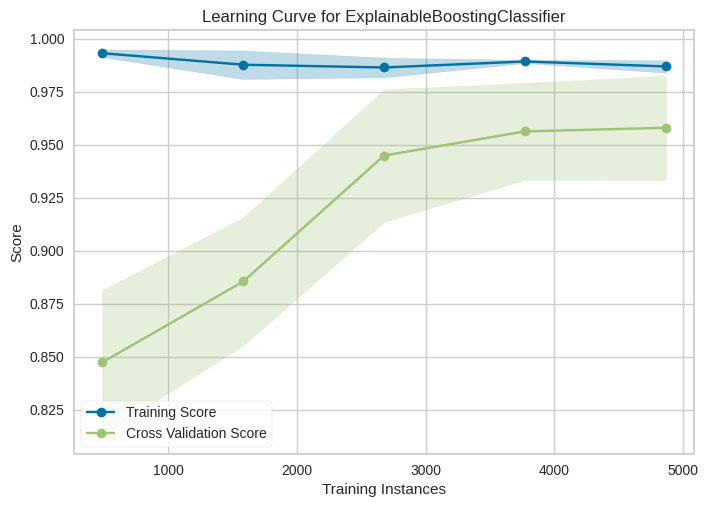

In [11]:
if True:
    cv = 5
    visualizer = LearningCurve(estimator=ebm, cv=cv, scoring='f1_macro', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="ebm_data/learning_curve.png")


![Alt text](ebm_data/learning_curve.png)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [13]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    ebm.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = ebm.predict(X_res.iloc[train_index])
    y_predicted_test = ebm.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='macro')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='macro')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9873
Test F1: 0.9290
Fold 1:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9871
Test F1: 0.9828
Fold 2:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9908
Test F1: 0.9508
Fold 3:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9868
Test F1: 0.8736
Fold 4:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9847
Test F1: 0.9820
Average Train F1: 0.9873
Average Test F1: 0.9436


In [14]:
%time ebm.fit(X_train, y_train)

CPU times: user 811 ms, sys: 123 ms, total: 934 ms
Wall time: 1min 4s


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


ExplainableBoostingClassifier()

In [15]:
%time y_predicted_train = ebm.predict(X_train)
%time y_predicted_test = ebm.predict(X_test)

CPU times: user 18 ms, sys: 1.62 ms, total: 19.6 ms
Wall time: 19 ms
CPU times: user 6.41 ms, sys: 348 µs, total: 6.76 ms
Wall time: 6.78 ms


In [16]:
performanceMetricsDFWeighted(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'macro')

,Measure,Train,Test
0,ACCURACY,0.985705,0.982260
1,PRECISION,0.988418,0.988231
2,RECALL,0.987268,0.936260
3,F1 SCORE,0.987211,0.955367


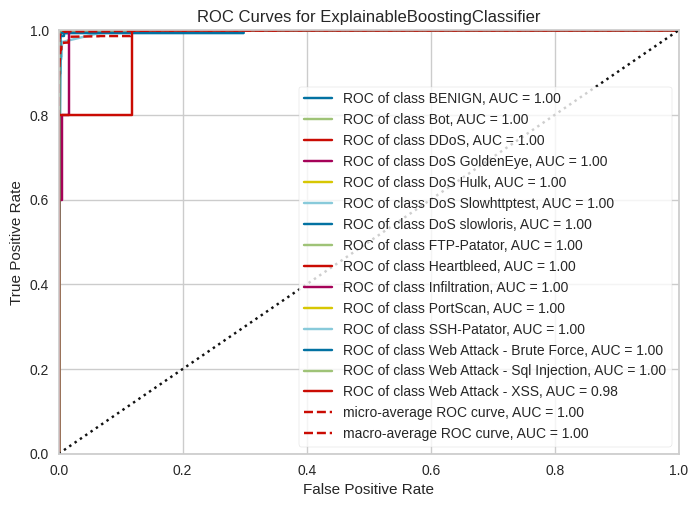

<Axes: title={'center': 'ROC Curves for ExplainableBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
model = wrap(ebm)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

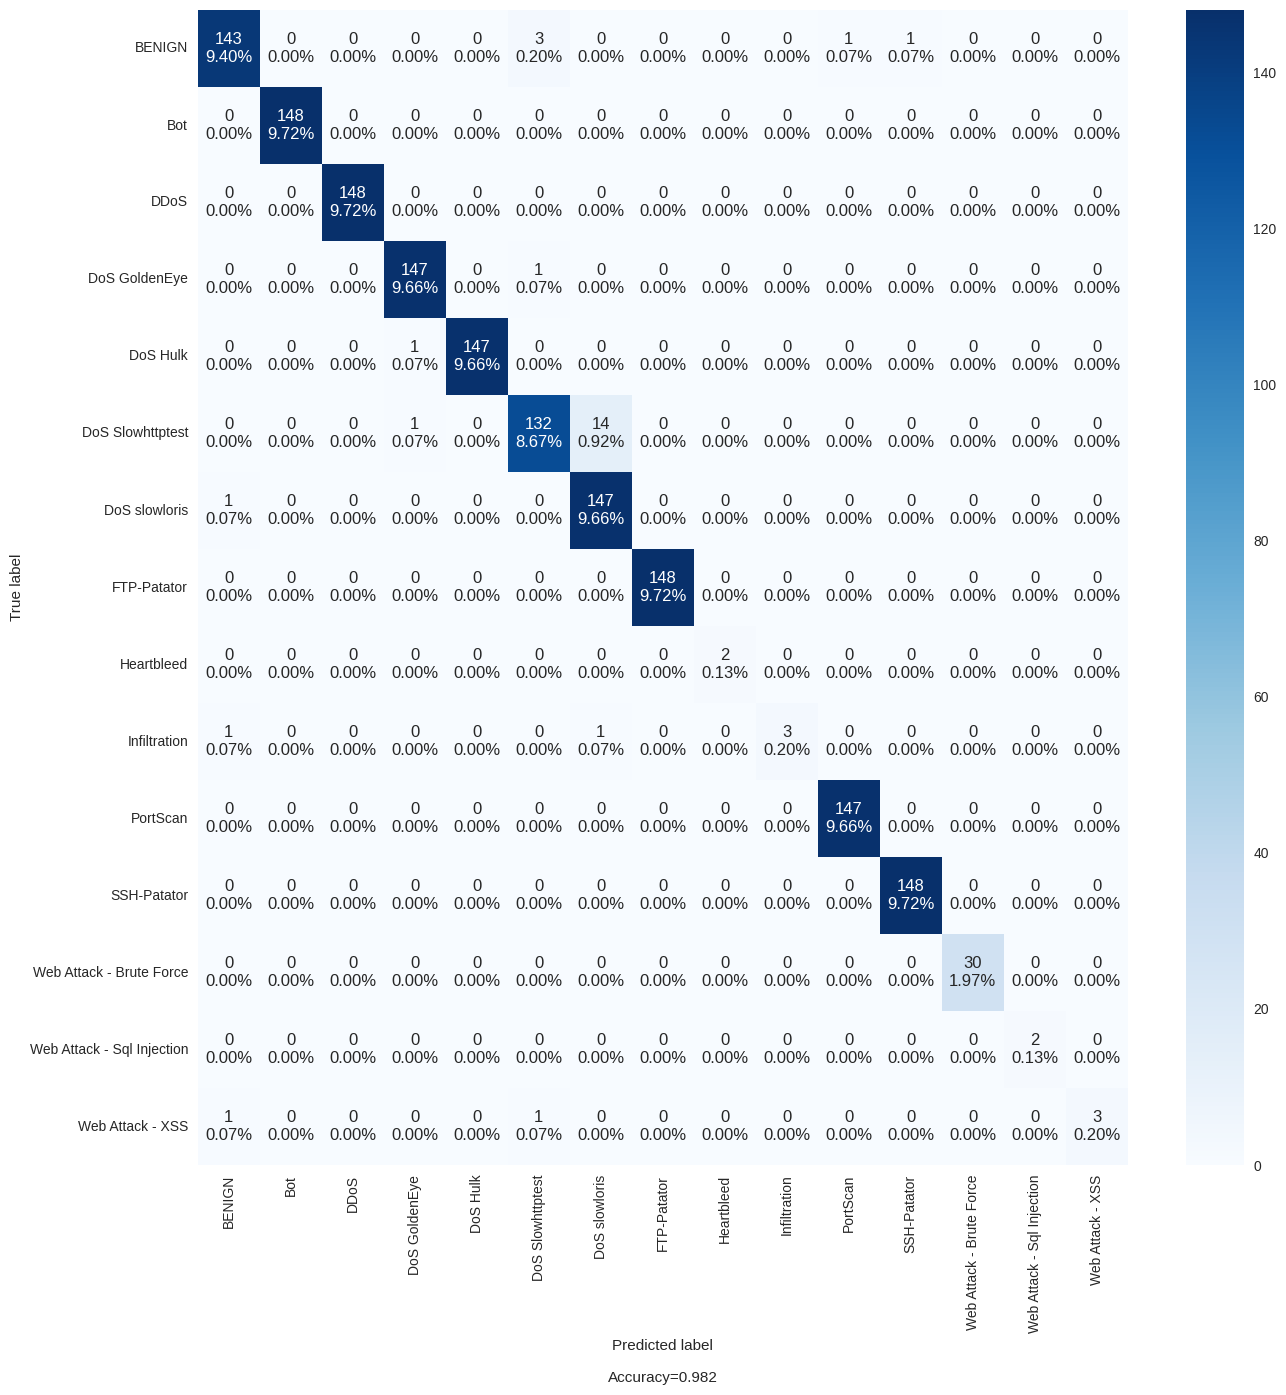

In [18]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(ebm.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [19]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/139876033980688/ -->

In [20]:
preserve(ebm.explain_global())

## Zero day test

In [21]:
classes = sorted(pd.unique(ds['label']).tolist())

In [22]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bot']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.984352,0.885677
1,PRECISION,0.985983,0.838243
2,RECALL,0.984352,0.885677
3,F1 SCORE,0.984265,0.853702


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



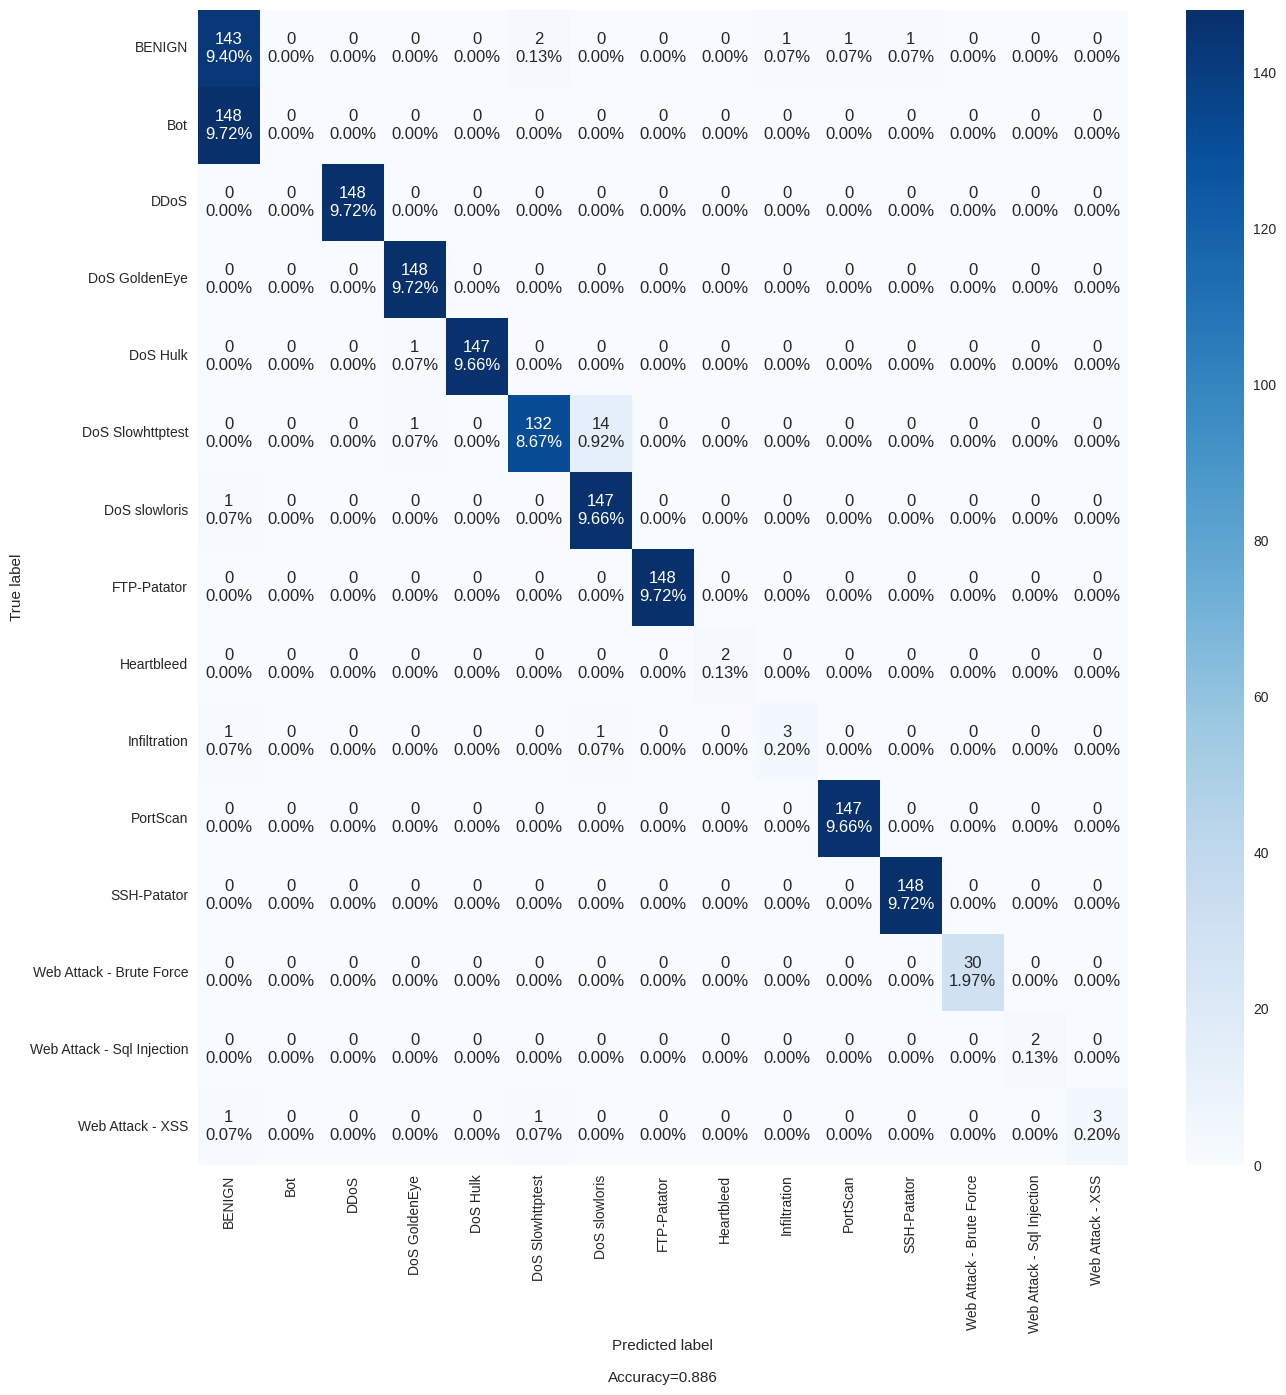

In [23]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [24]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DDoS']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.983806,0.885677
1,PRECISION,0.985478,0.821998
2,RECALL,0.983806,0.885677
3,F1 SCORE,0.983729,0.846754


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



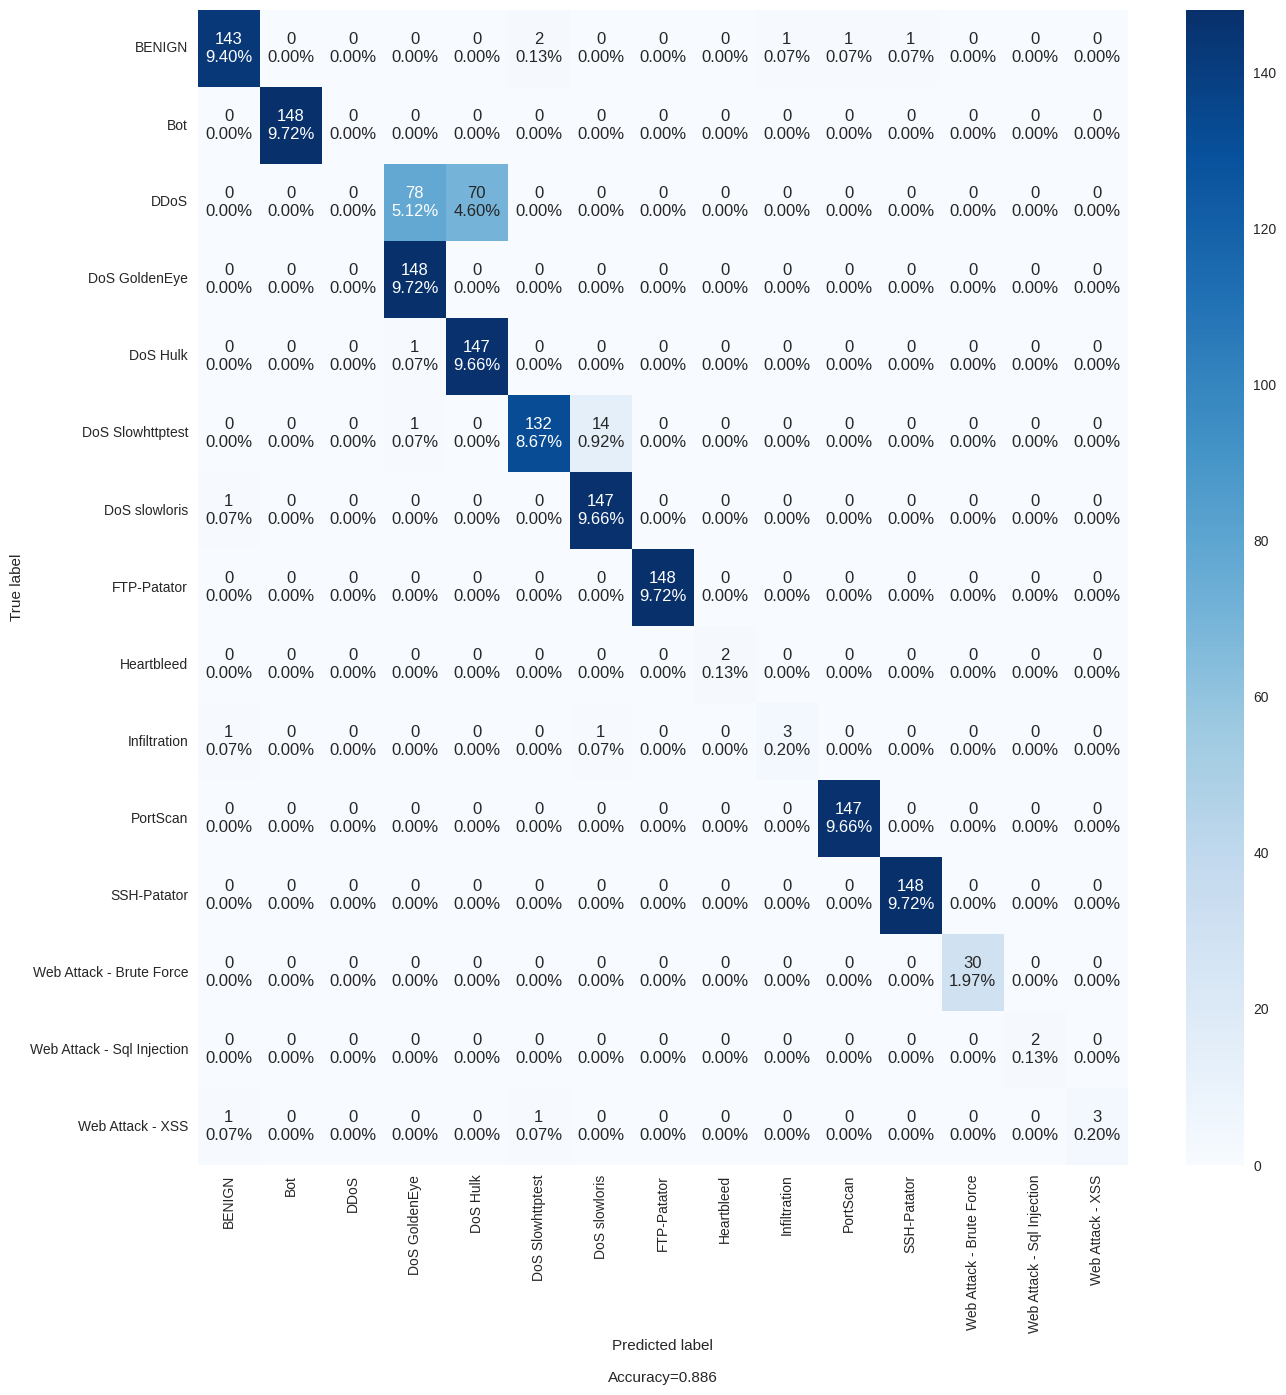

In [25]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [26]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS GoldenEye']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.985080,0.886991
1,PRECISION,0.986818,0.822023
2,RECALL,0.985080,0.886991
3,F1 SCORE,0.985040,0.848499


/tmp/ipykernel_139583/1563505262.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



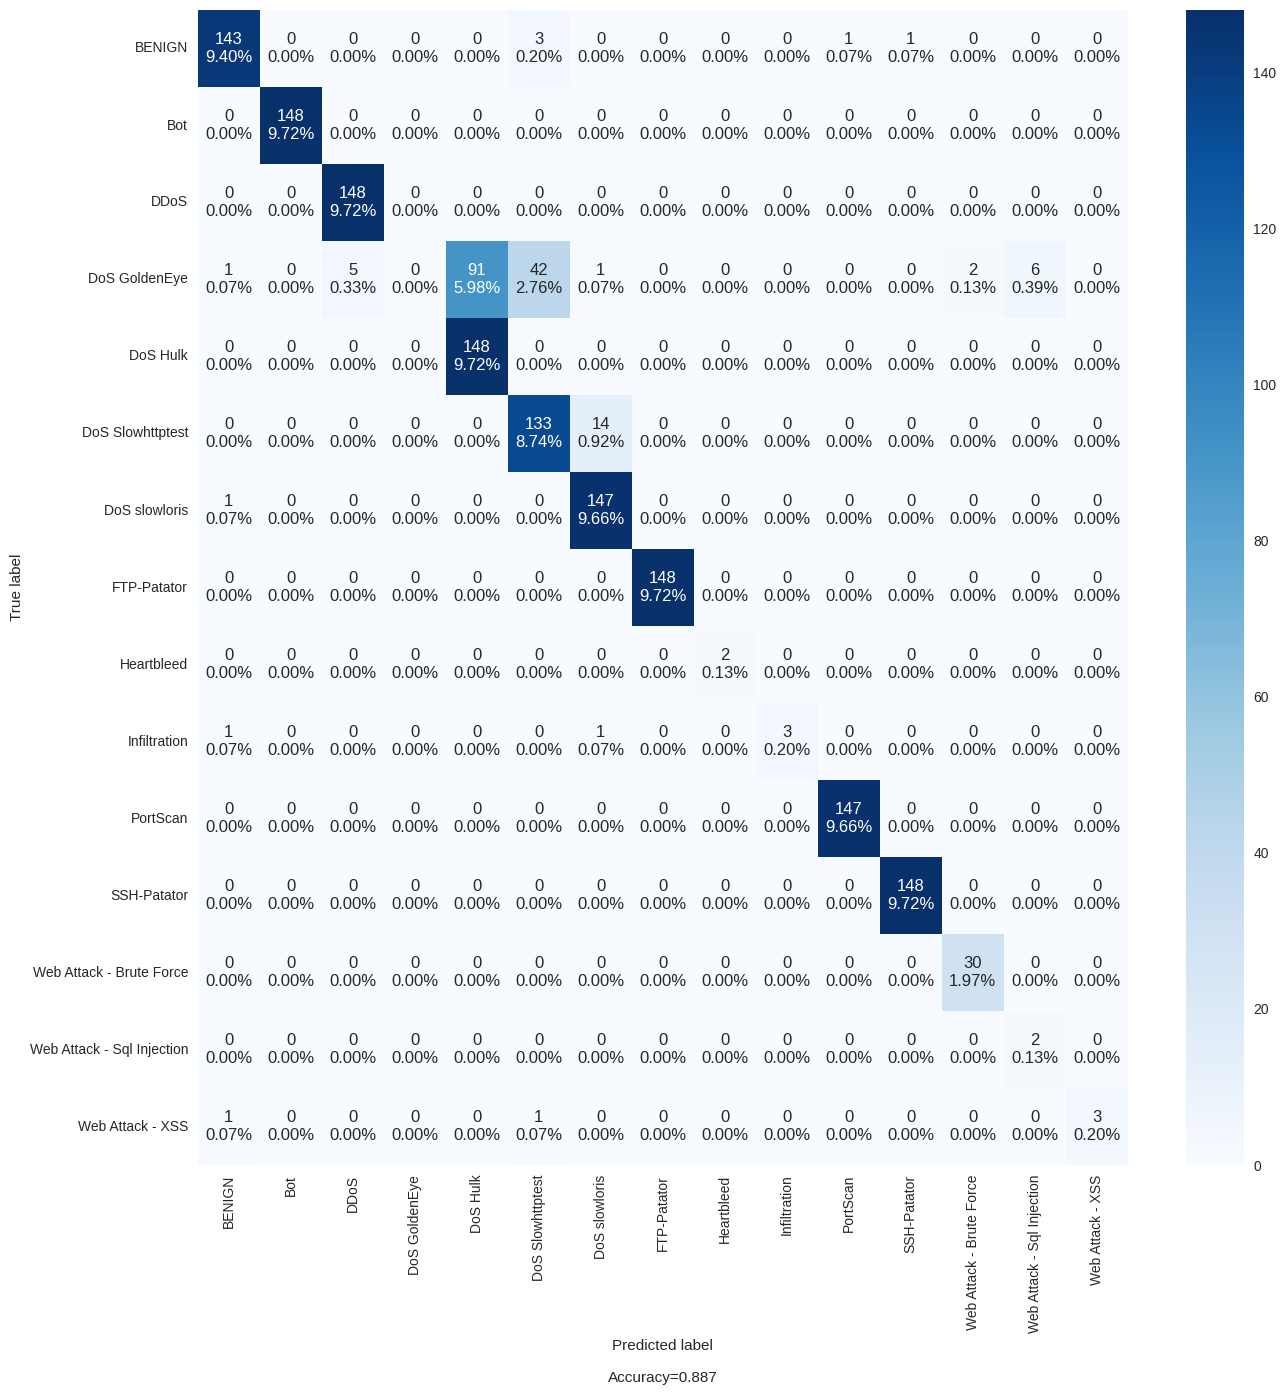

In [27]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf,
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [28]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS Hulk']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.983806,0.886334
1,PRECISION,0.985471,0.814878
2,RECALL,0.983806,0.886334
3,F1 SCORE,0.983728,0.844864


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



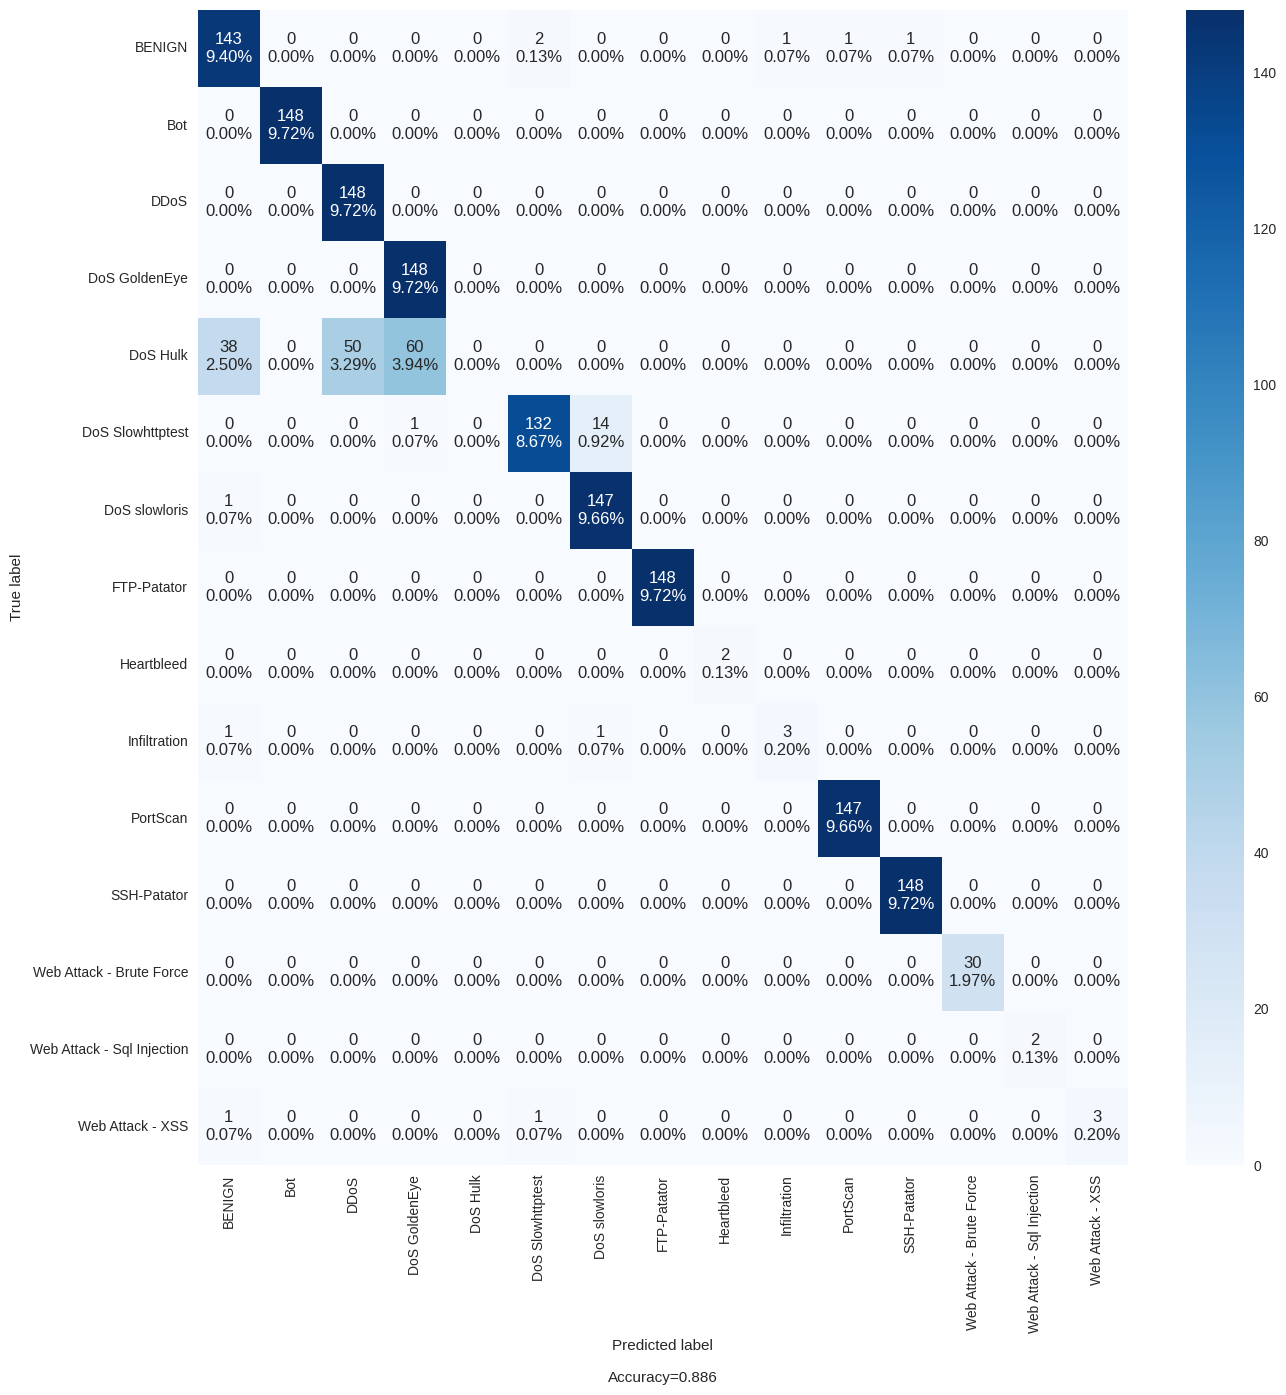

In [29]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [30]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS Slowhttptest']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.998908,0.897503
1,PRECISION,0.998909,0.838304
2,RECALL,0.998908,0.897503
3,F1 SCORE,0.998908,0.860997


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



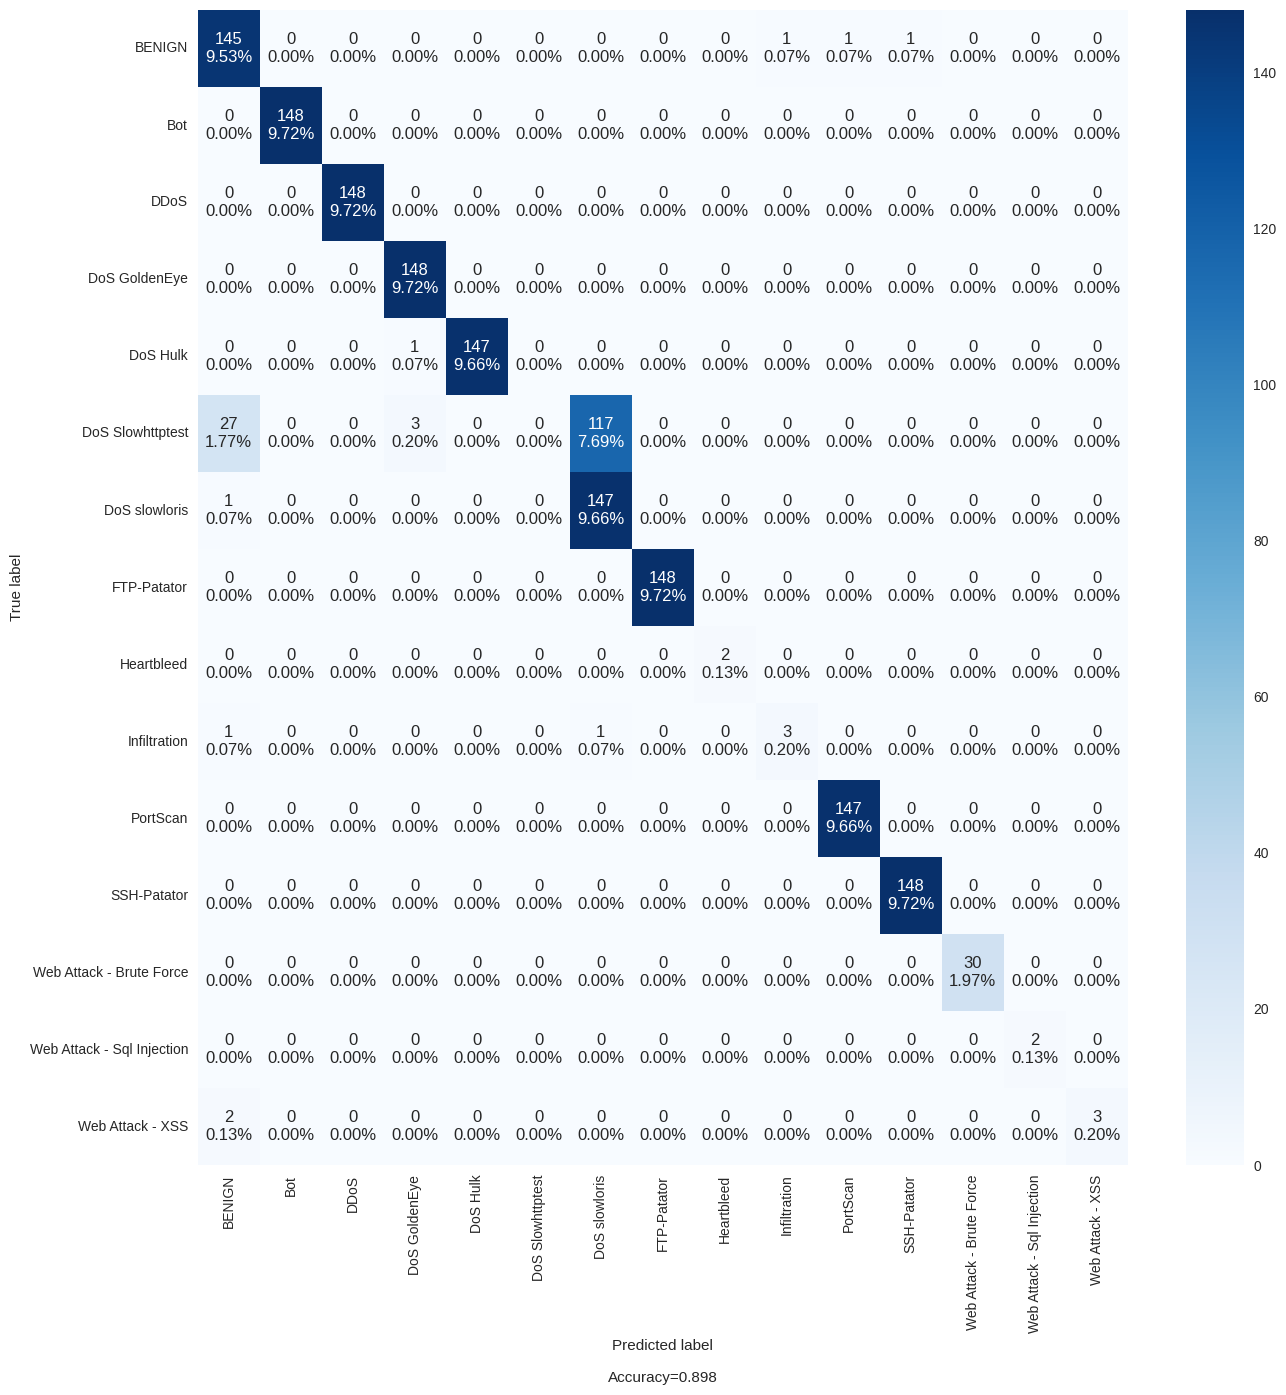

In [31]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [32]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS slowloris']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.998362,0.897503
1,PRECISION,0.998364,0.843378
2,RECALL,0.998362,0.897503
3,F1 SCORE,0.998360,0.862919


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



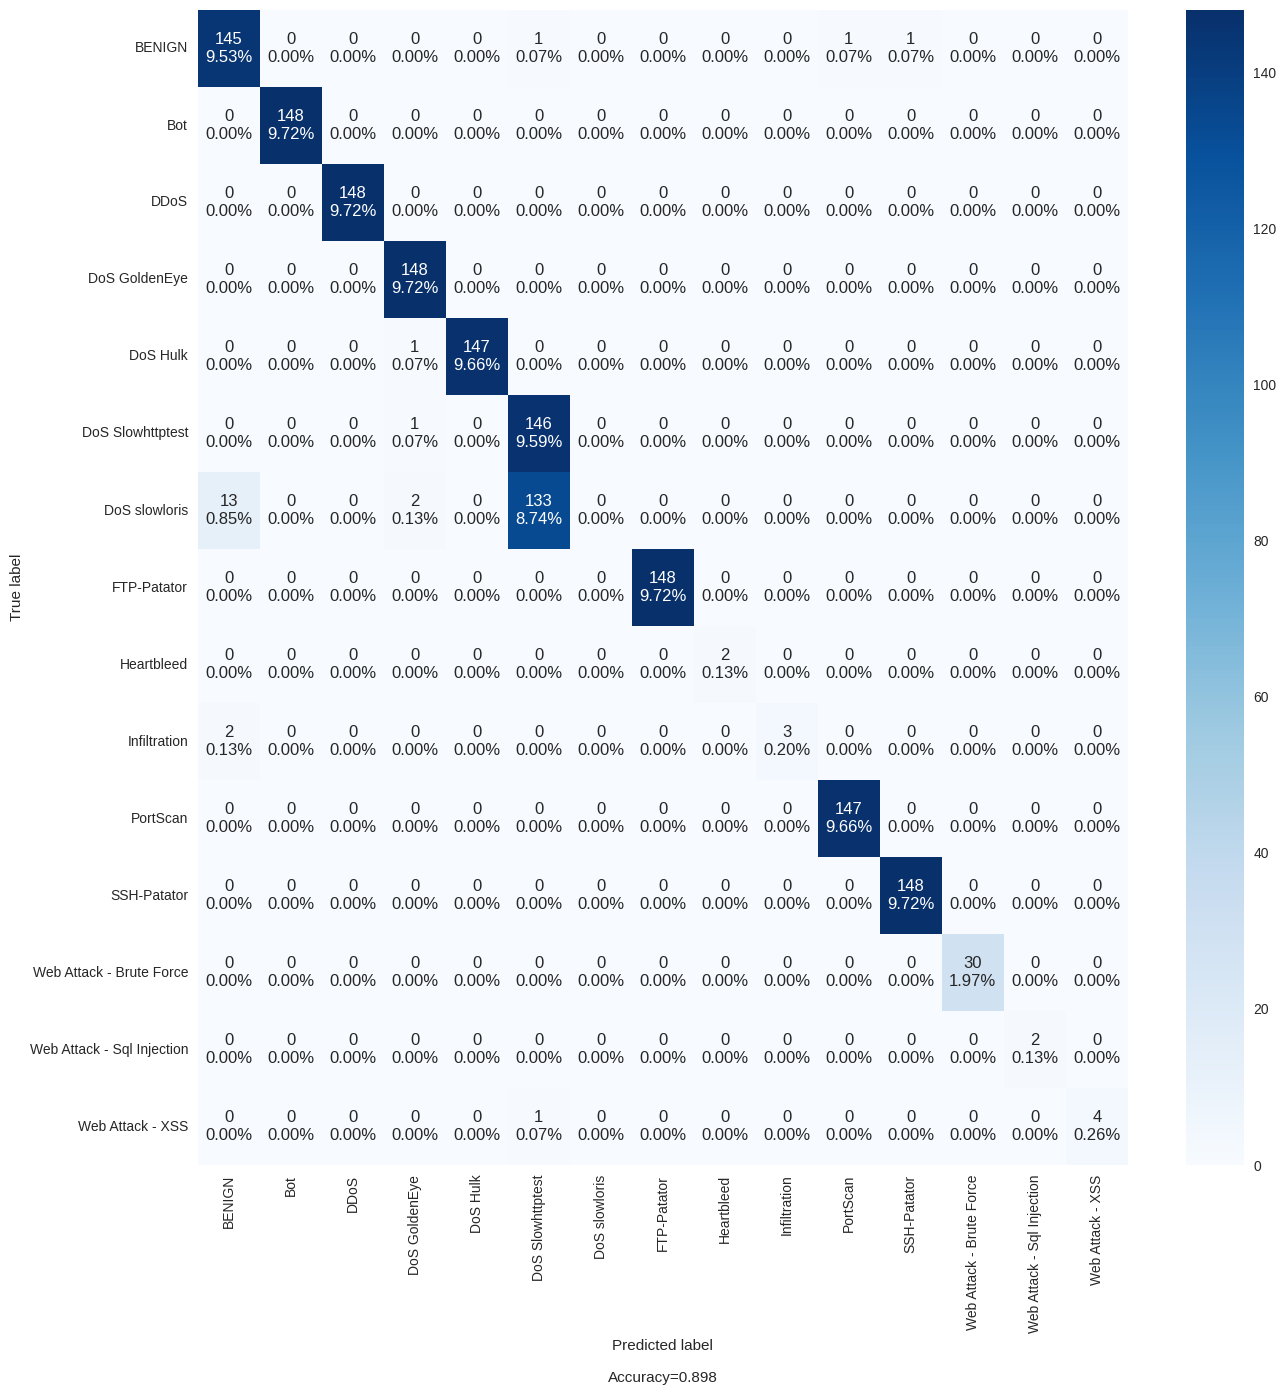

In [33]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [34]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'FTP-Patator']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.982715,0.885020
1,PRECISION,0.984414,0.836055
2,RECALL,0.982715,0.885020
3,F1 SCORE,0.982628,0.851993


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



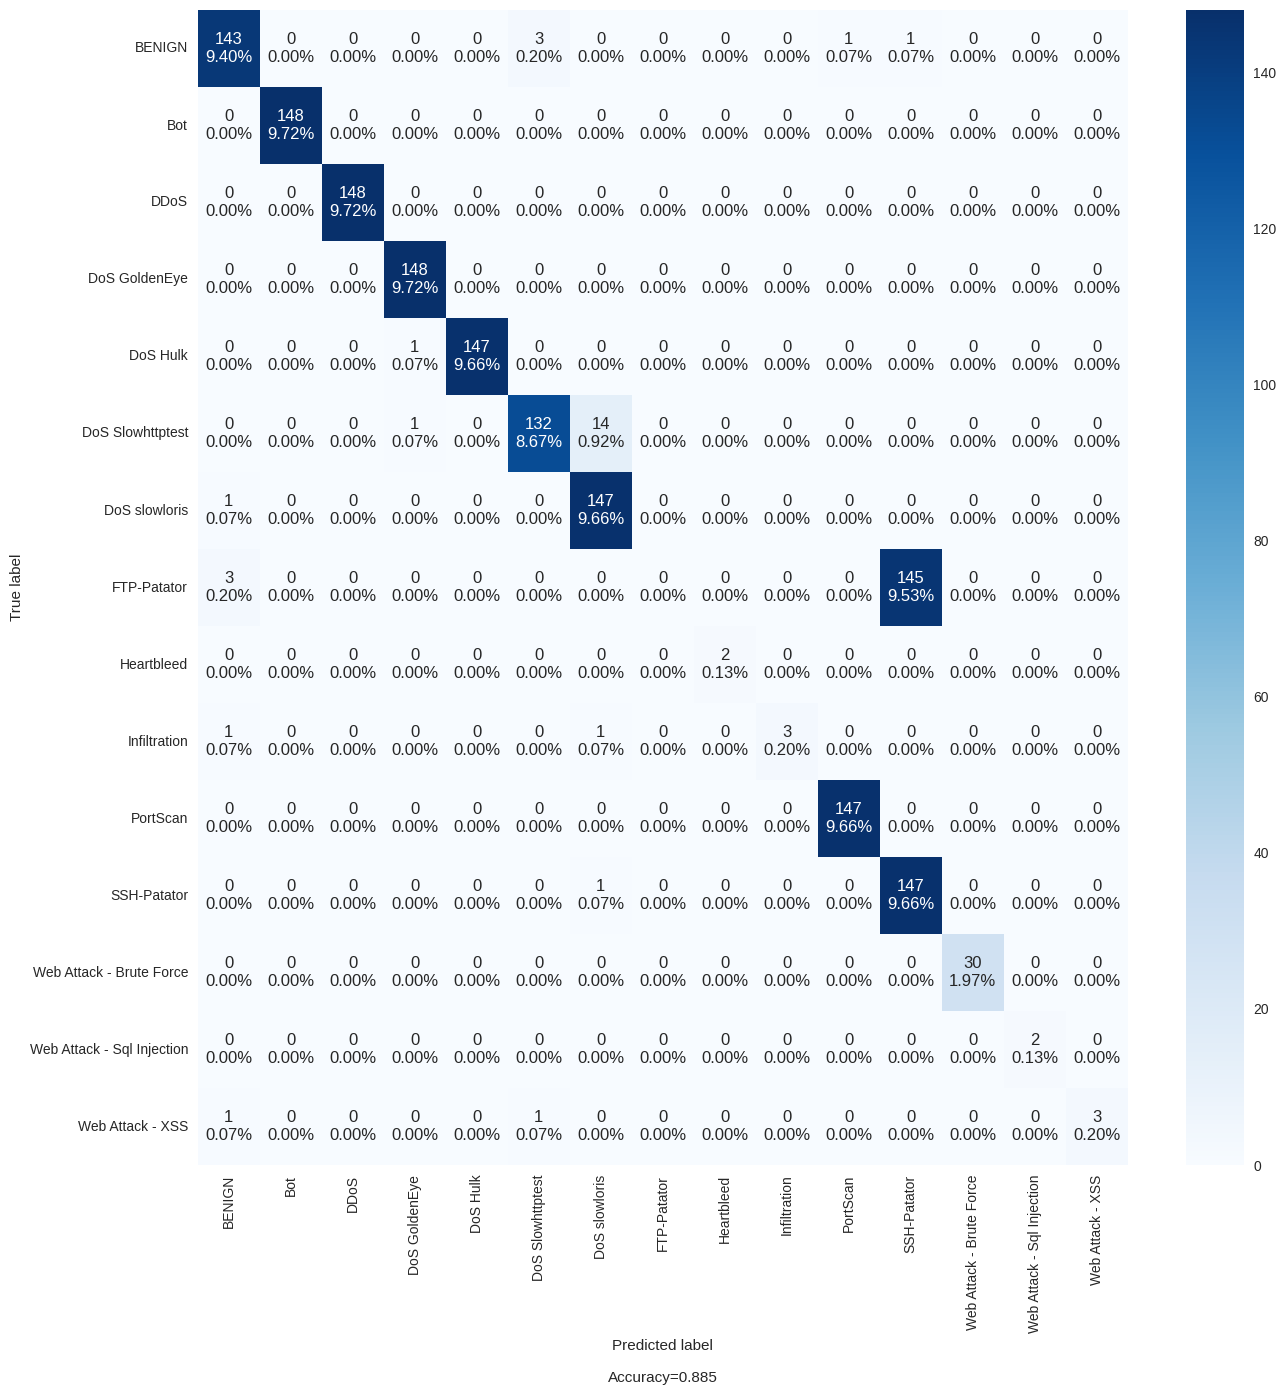

In [35]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [36]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Heartbleed']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.985519,0.982260
1,PRECISION,0.987056,0.981909
2,RECALL,0.985519,0.982260
3,F1 SCORE,0.985449,0.981692


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



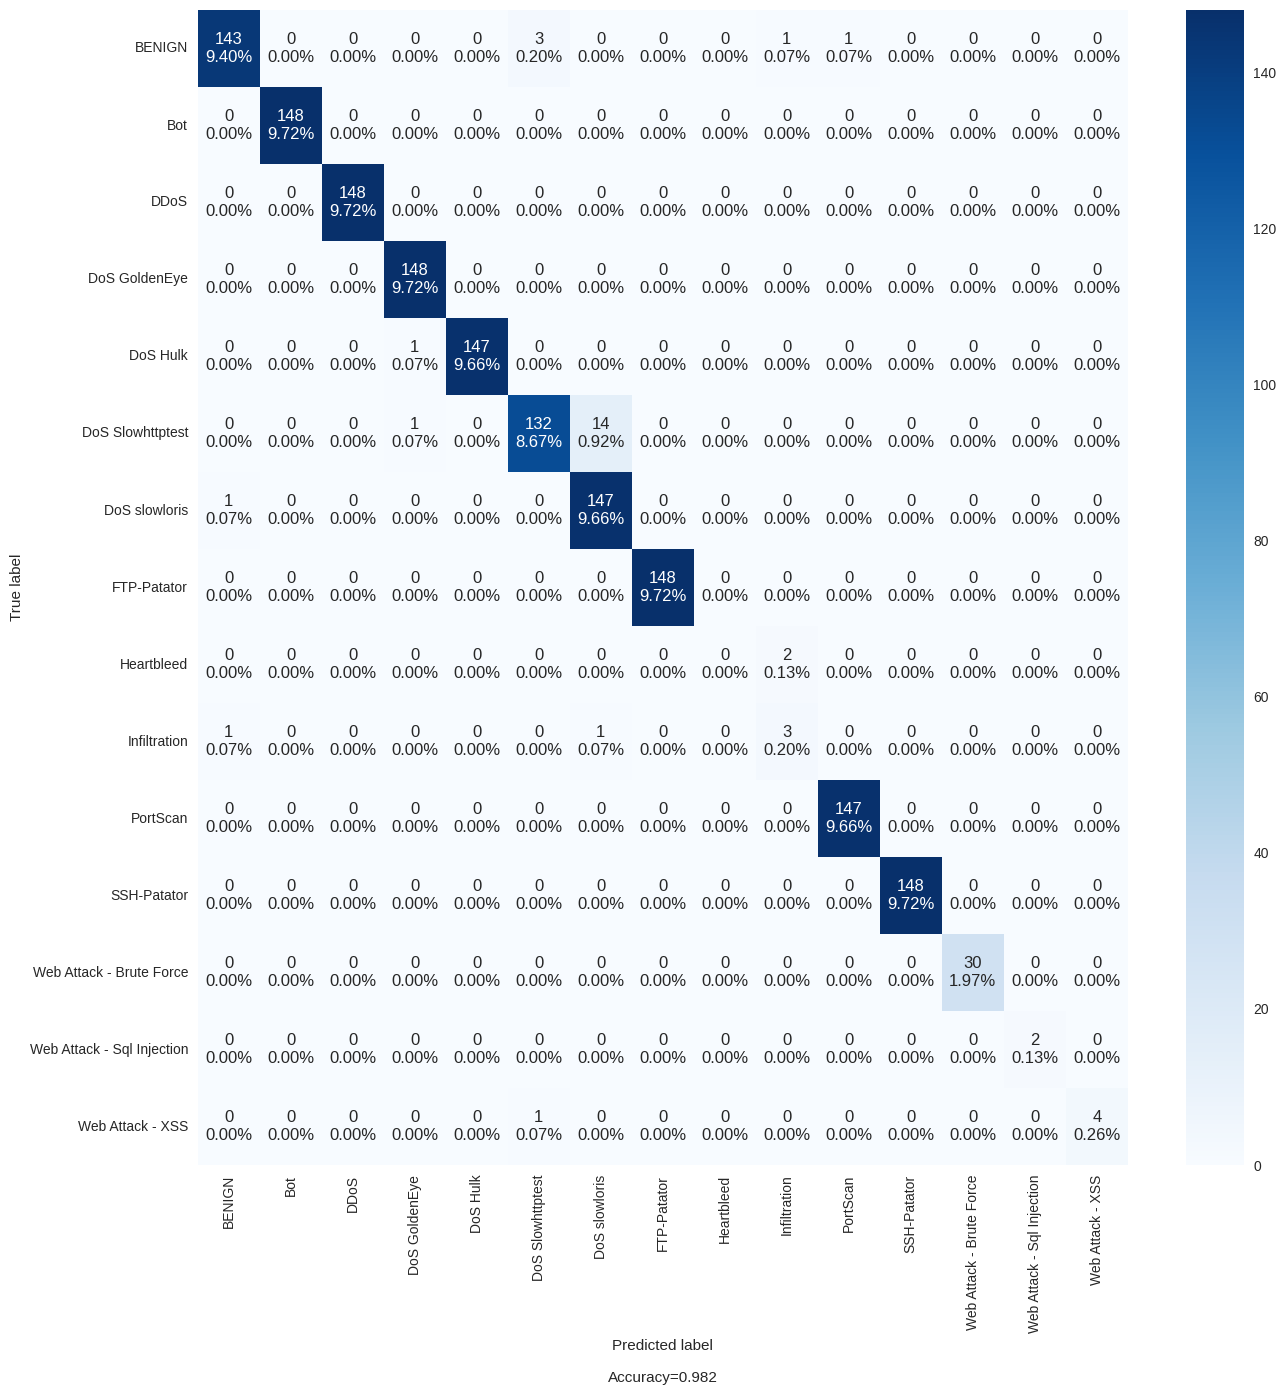

In [37]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [38]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Infiltration']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.985488,0.980289
1,PRECISION,0.986960,0.977726
2,RECALL,0.985488,0.980289
3,F1 SCORE,0.985407,0.978508


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



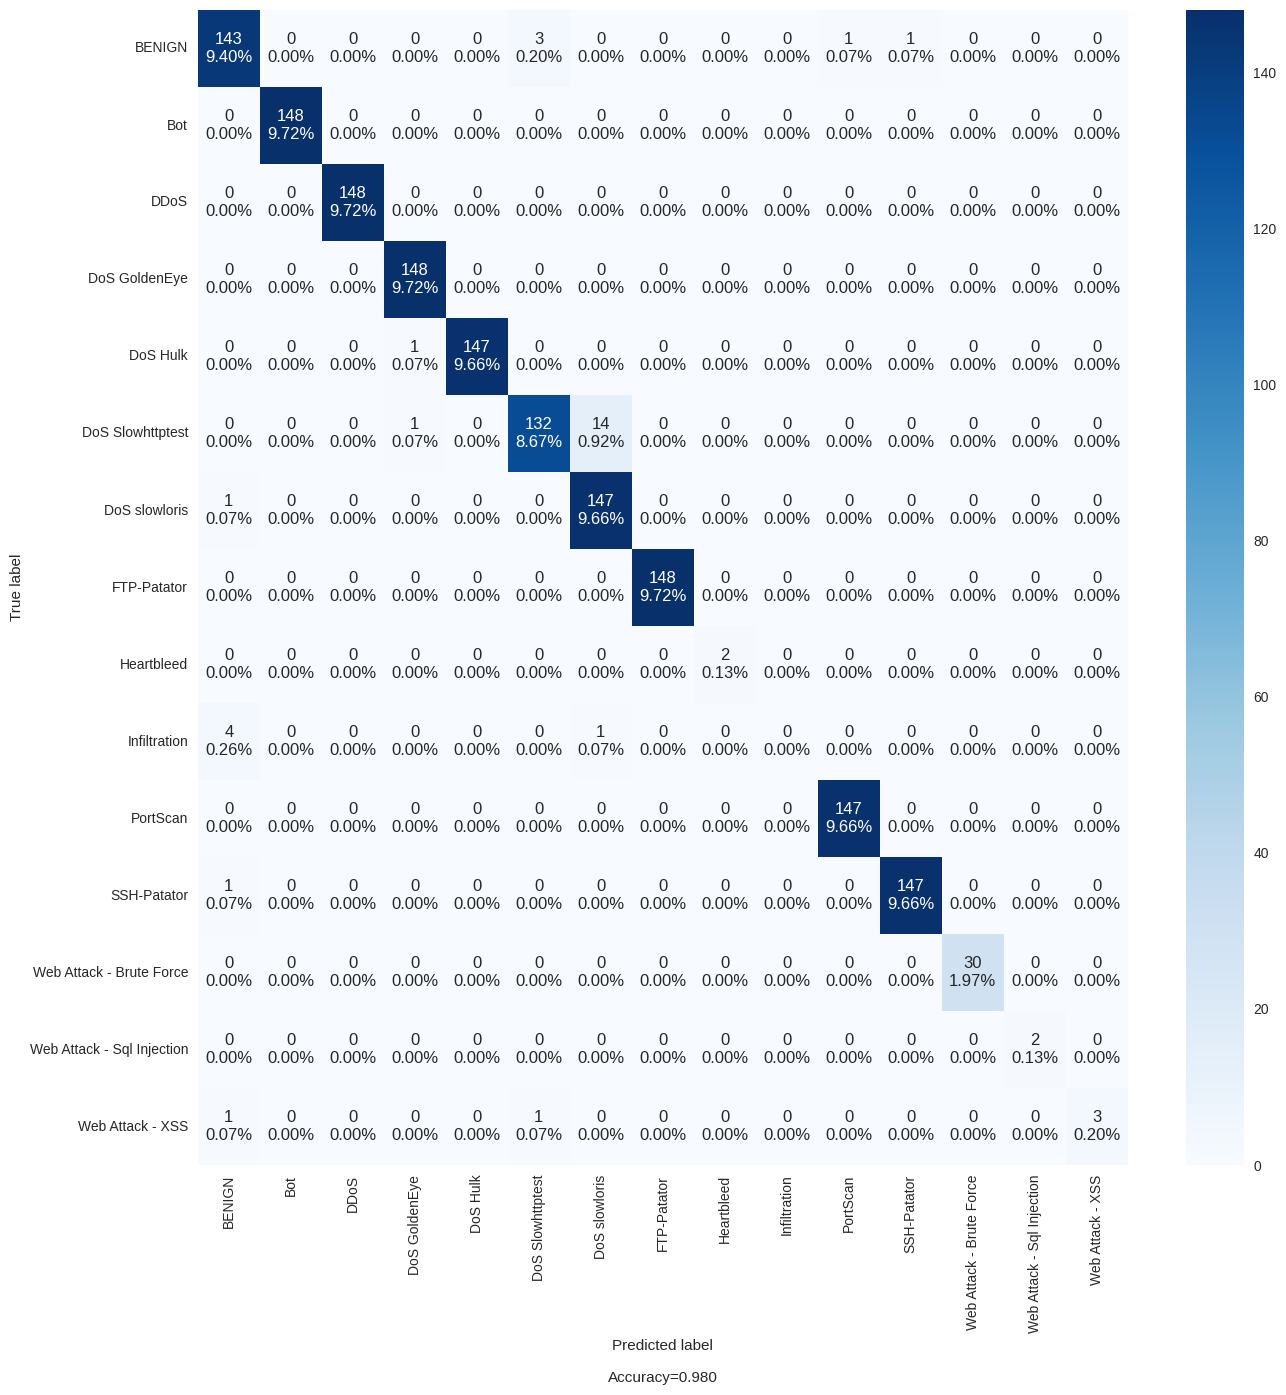

In [39]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [40]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'PortScan']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.984167,0.886334
1,PRECISION,0.985827,0.845463
2,RECALL,0.984167,0.886334
3,F1 SCORE,0.984079,0.856646


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



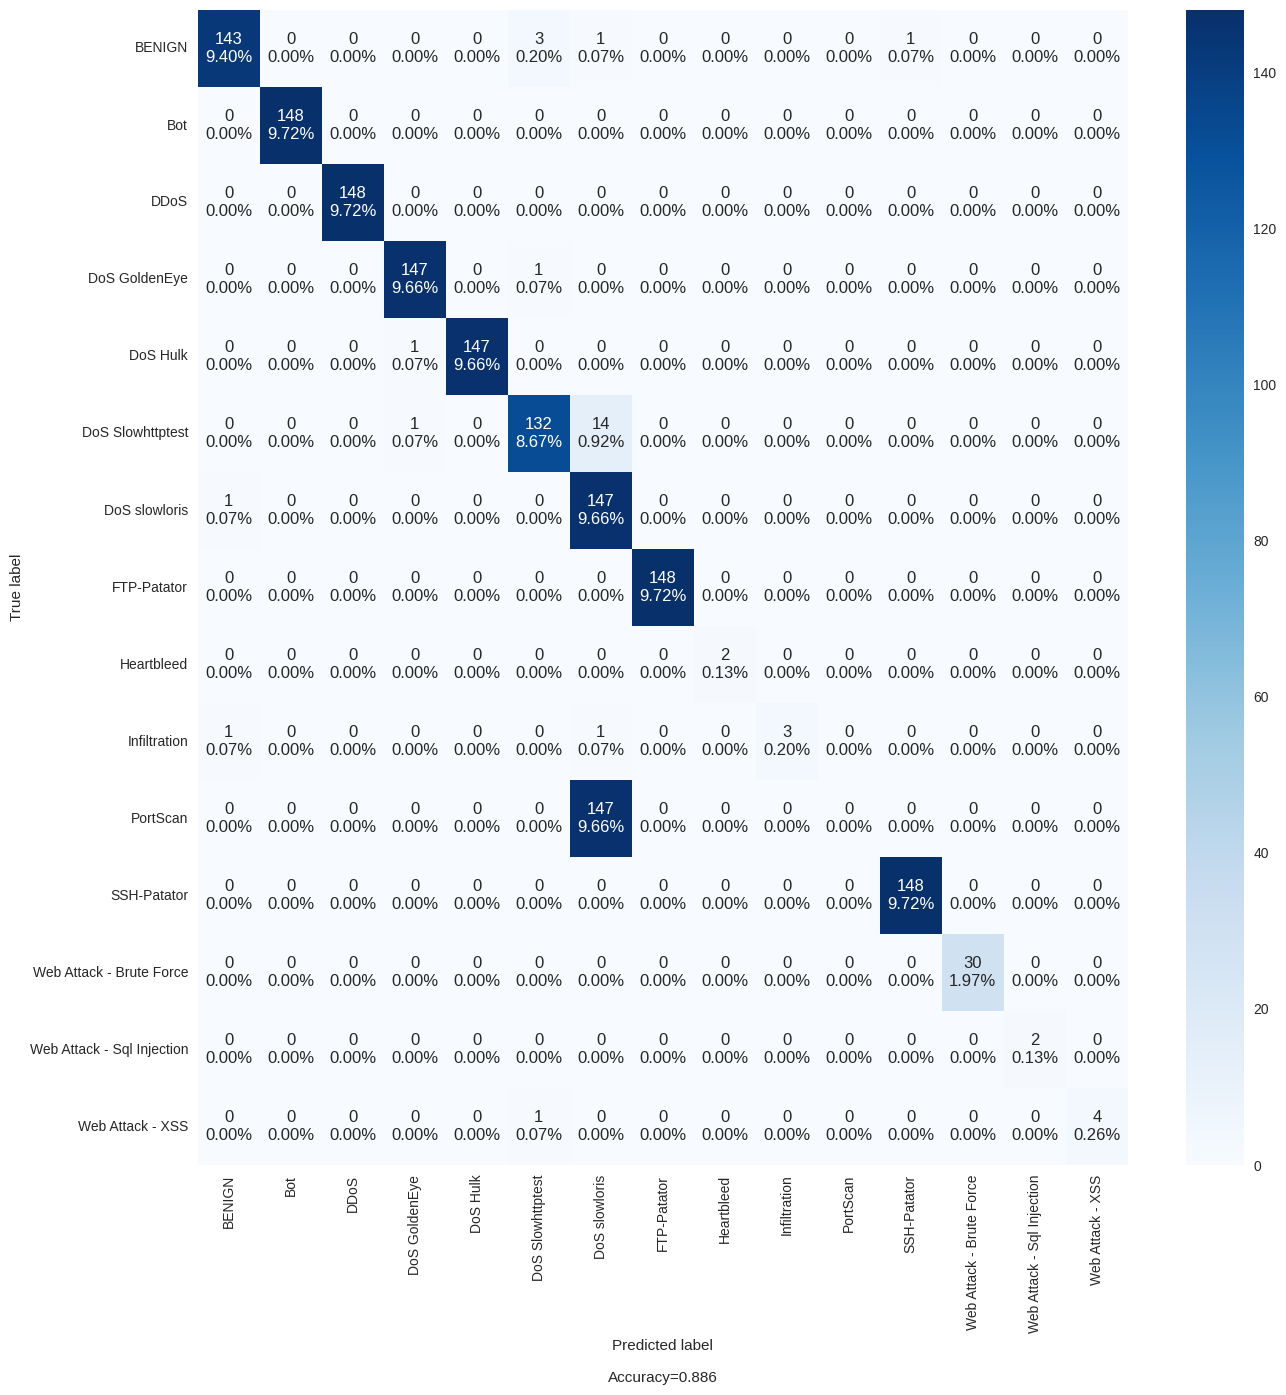

In [41]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [42]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'SSH-Patator']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.983806,0.886334
1,PRECISION,0.985503,0.838237
2,RECALL,0.983806,0.886334
3,F1 SCORE,0.983723,0.853919


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



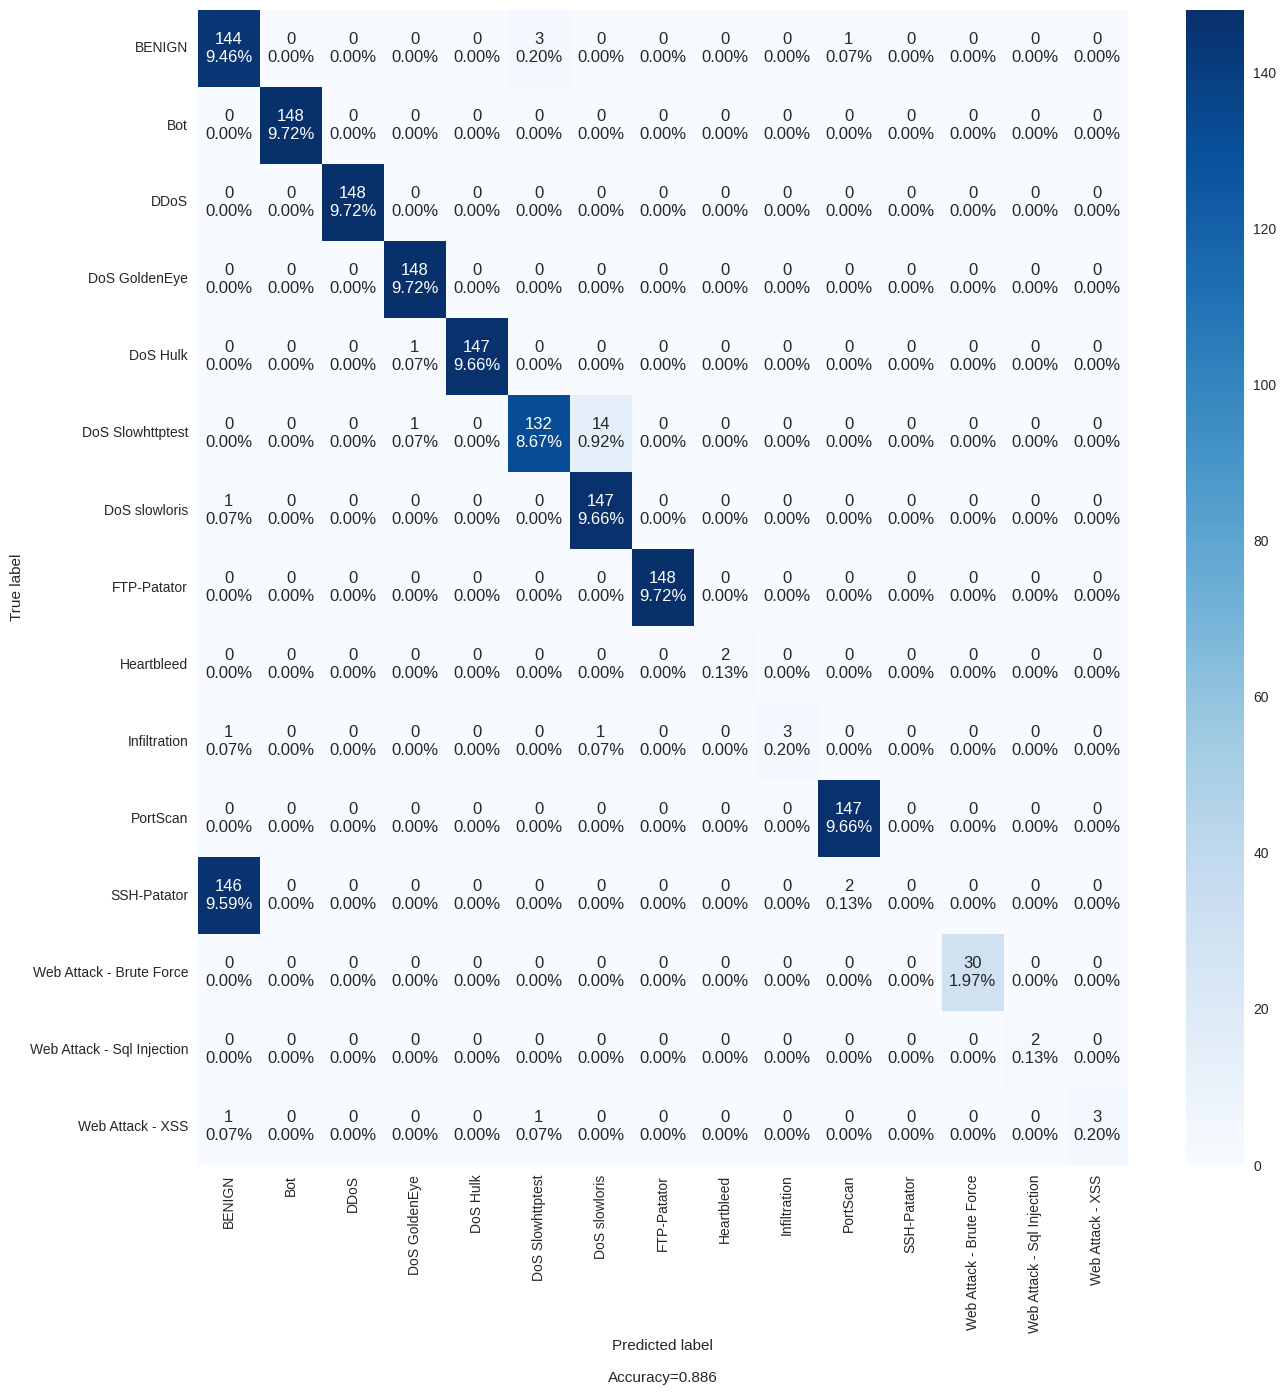

In [43]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [44]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Web Attack - Brute Force']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.982733,0.959264
1,PRECISION,0.984979,0.950440
2,RECALL,0.982733,0.959264
3,F1 SCORE,0.982592,0.953352


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



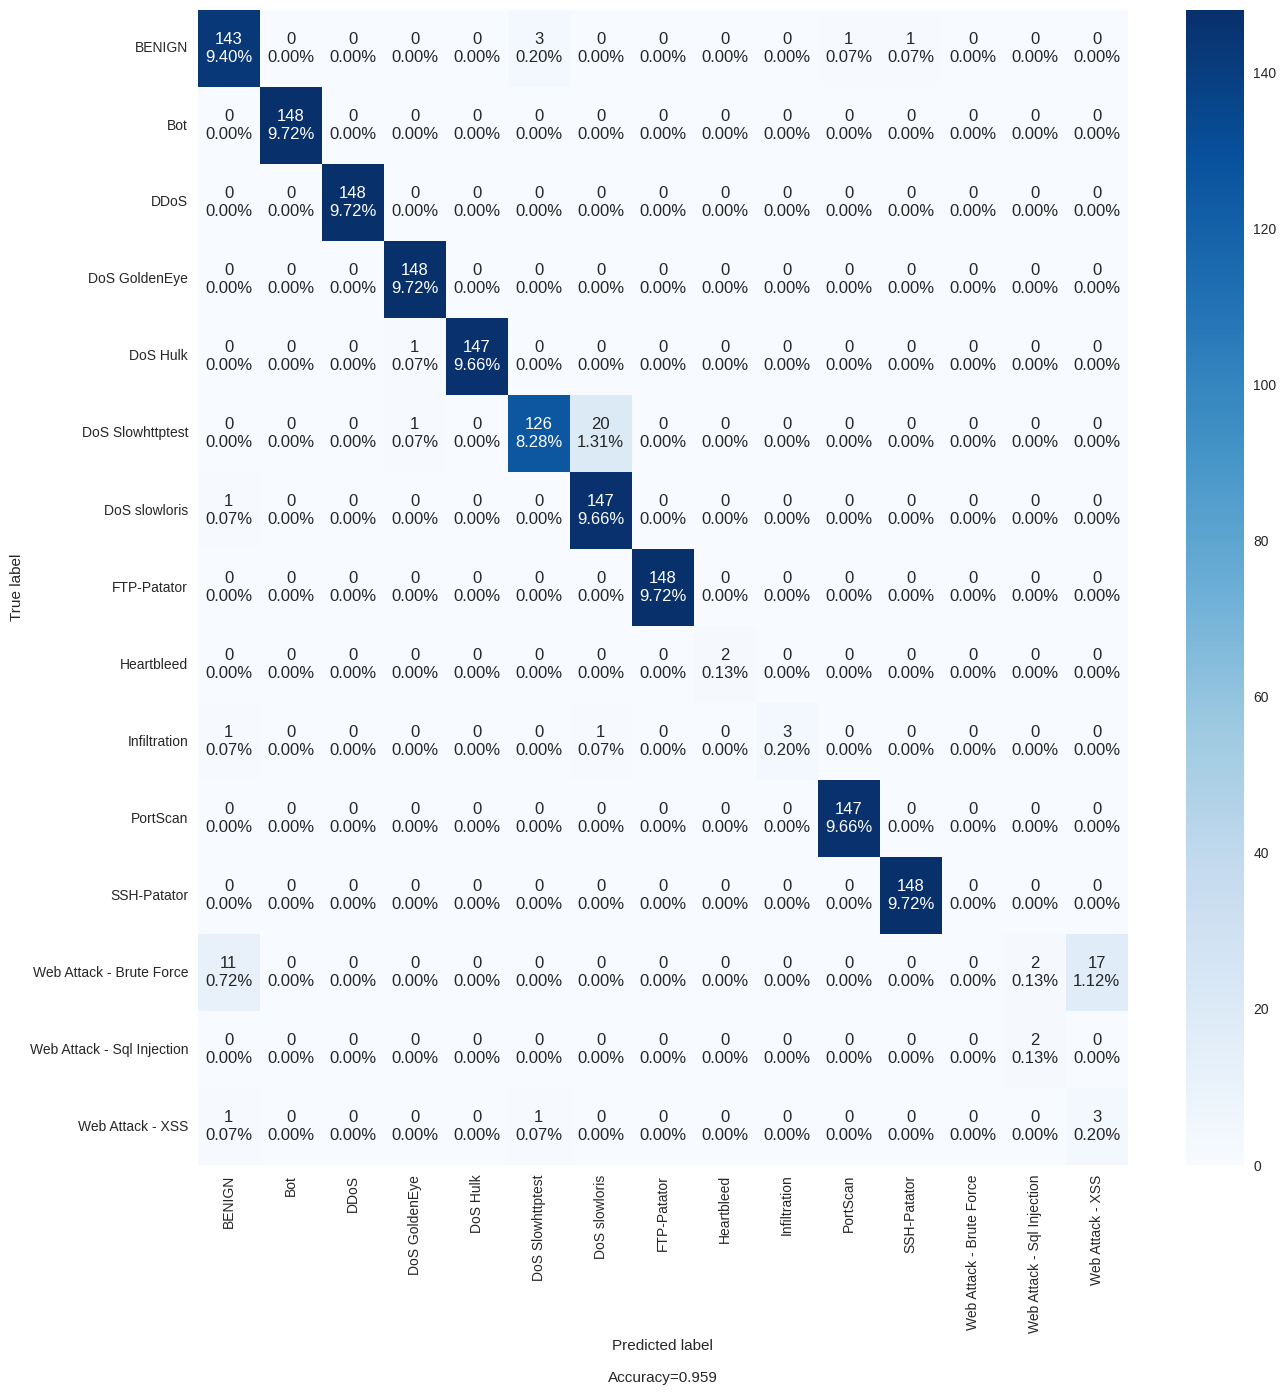

In [45]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [46]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Web Attack - Sql Injection']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.985517,0.981603
1,PRECISION,0.986992,0.980776
2,RECALL,0.985517,0.981603
3,F1 SCORE,0.985438,0.980818


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



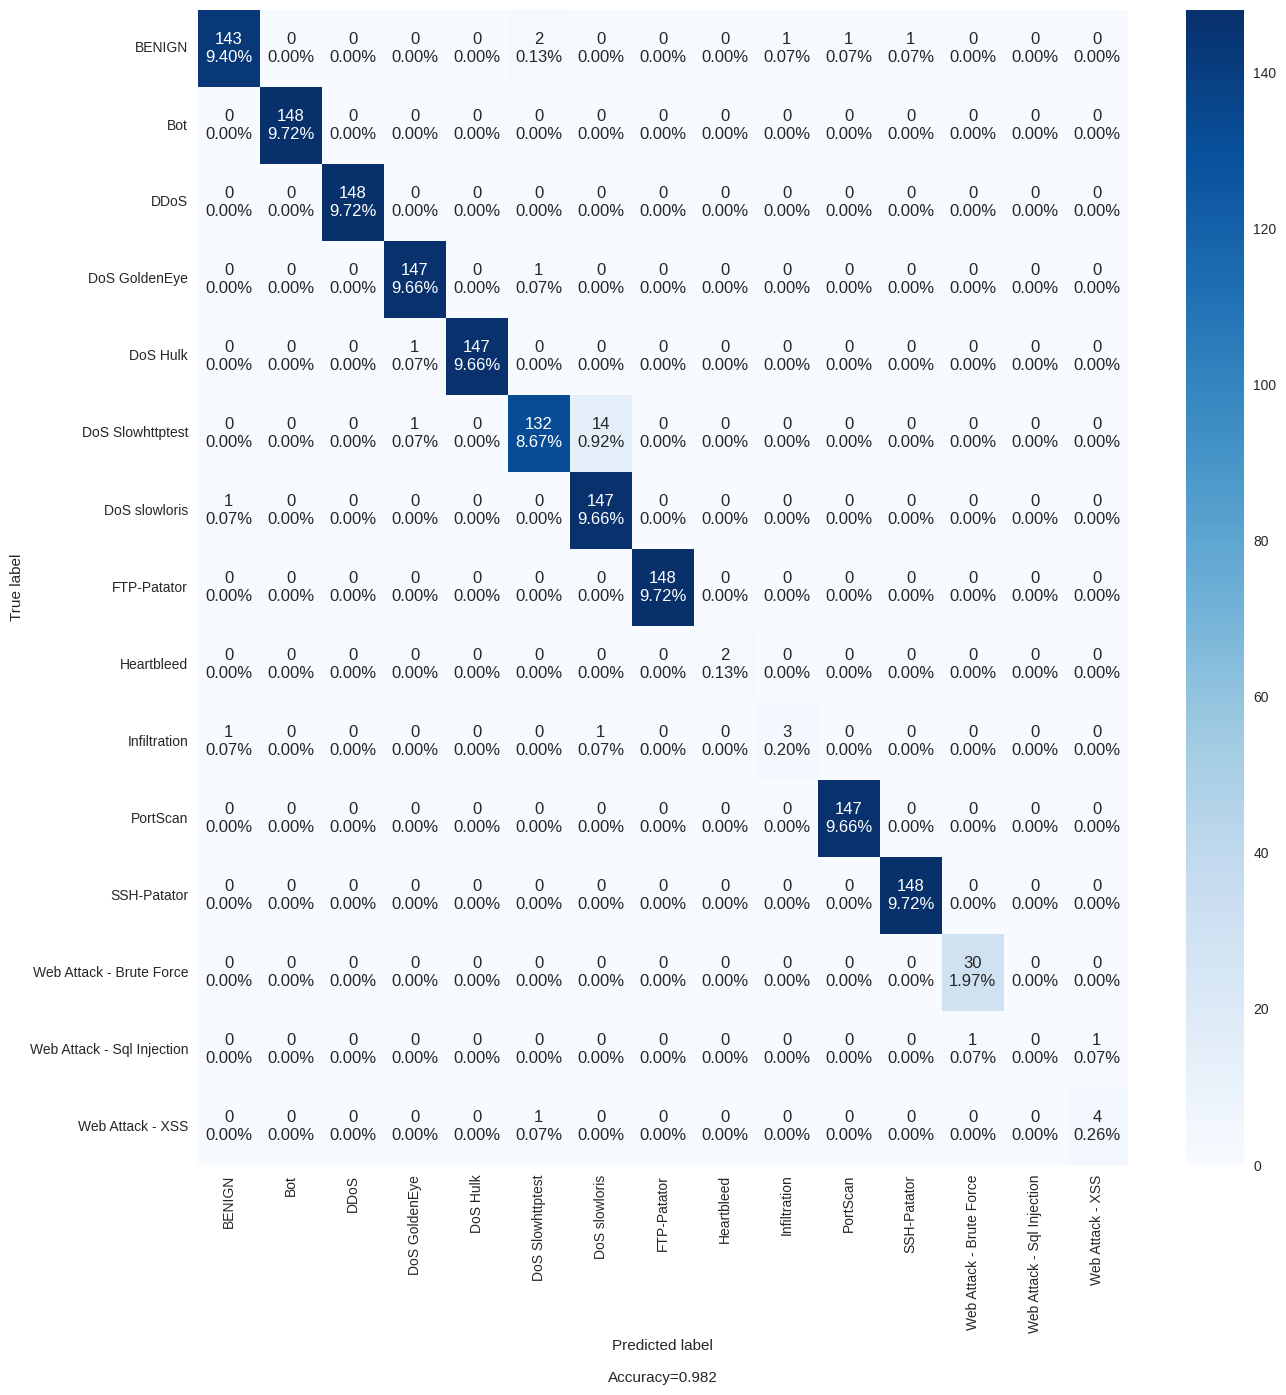

In [47]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [48]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Web Attack - XSS']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.985323,0.980946
1,PRECISION,0.986771,0.978403
2,RECALL,0.985323,0.980946
3,F1 SCORE,0.985242,0.979148


/tmp/ipykernel_139583/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



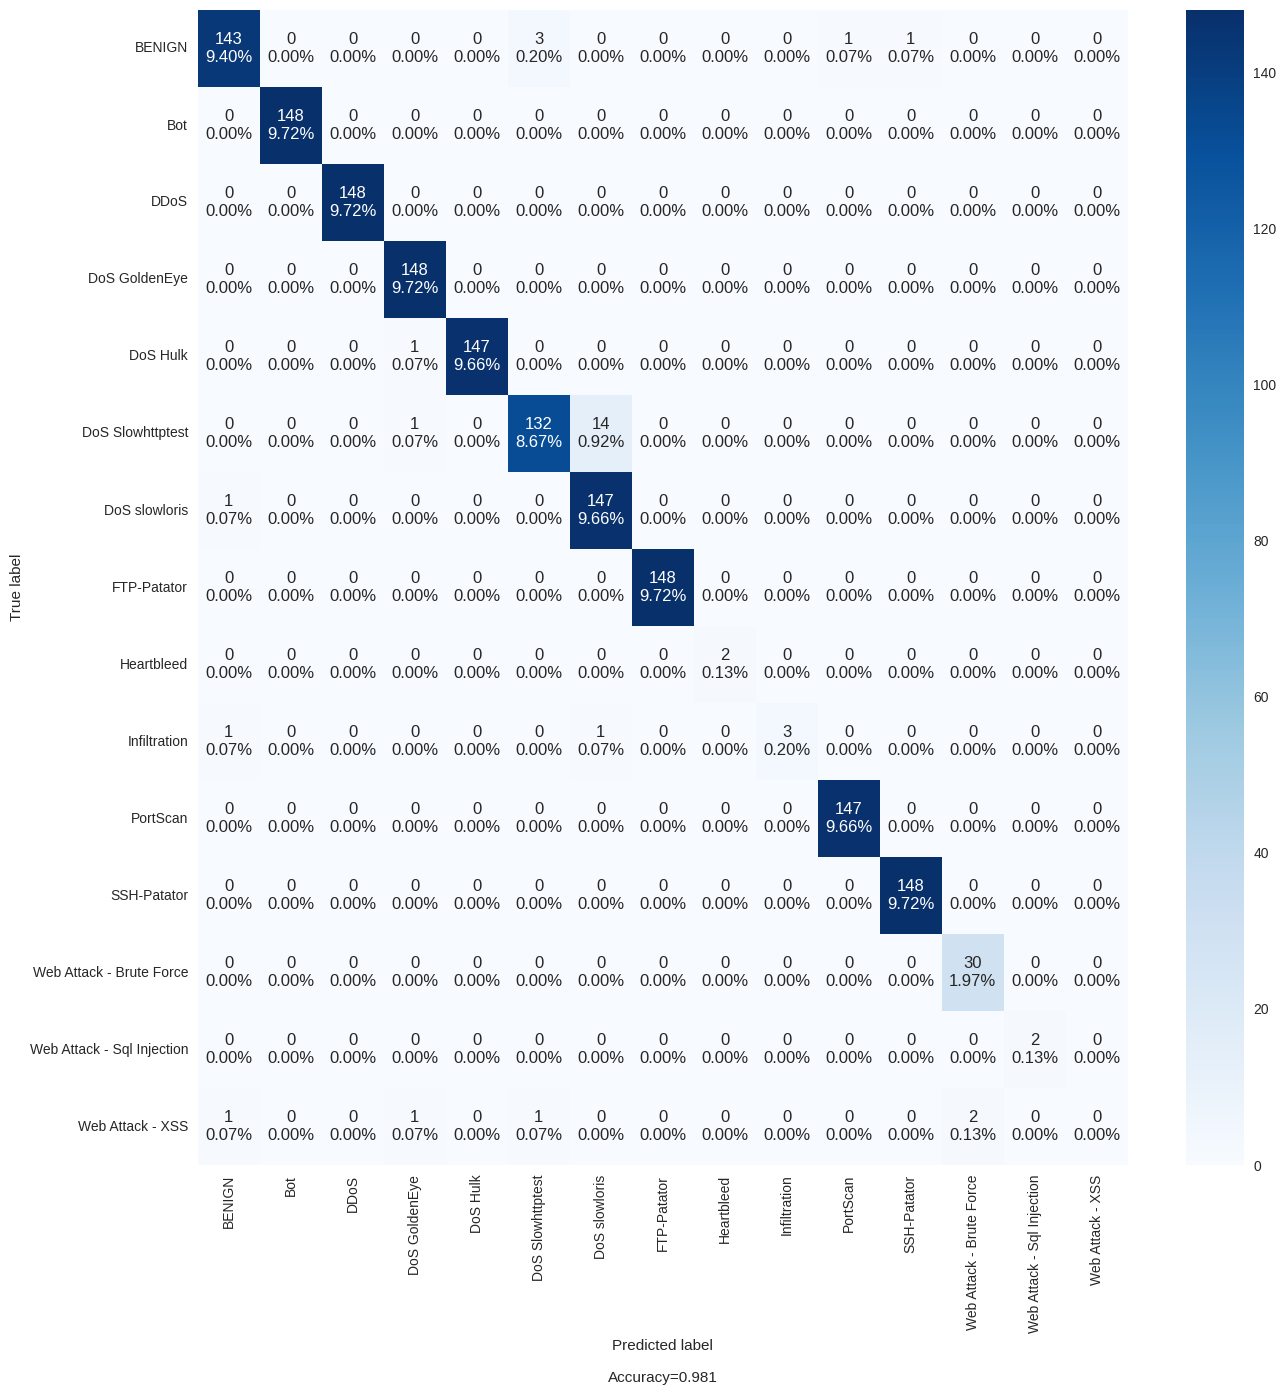

In [49]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))